In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

import datetime
from datetime import date

# Plots
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

# Classifier's metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# 1. Preprocesing data

### 1.1 Retrieve data

In [2]:
# Read dataset
data_folder = './data/'
data=pd.read_csv(data_folder + 'marketing_campaign.csv',header=0,sep=';', index_col = 'ID')

In [3]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,4/9/2012,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,8/3/2014,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21/8/2013,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10/2/2014,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19/1/2014,94,173,43,...,5,0,0,0,0,0,0,3,11,0


### 1.2 Analyze data and rename columns

In [4]:
# Calculate client's age
data['Age'] = 2021 - data['Year_Birth']

# Calculate total spent
data['Total_Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

#Seniority variable creation
last_date = date(2021, 12, 13)

In [5]:
# Calculate clients's seniority
data['Seniority']=pd.to_datetime(data['Dt_Customer'], dayfirst=True, format='%d/%m/%Y')
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')

# Rename some columns
data=data.rename(columns={'NumWebPurchases': "Web_Purchases",
                          'NumCatalogPurchases':'Catalog_Purchases',
                          'NumStorePurchases':'Store_Purchases', 
                          'NumWebVisitsMonth':'Web_Visits_Month',
                          'MntWines': "Wines",
                          'MntFruits':'Fruits',
                          'MntMeatProducts':'Meat',
                          'MntFishProducts':'Fish',
                          'MntSweetProducts':'Sweets',
                          'MntGoldProds':'Gold'})
data['Marital_Status'].replace({'Alone':'Single','Absurd':'Single','YOLO':'Single'}, inplace=True)

# Calculate the amount of children that a client has
data['Children'] = data['Kidhome'] + data['Teenhome']
data['Has_Child'] = (data.Children > 0)*1
# Filter just relevant client's features
data=data[['Age','Education','Marital_Status','Income','Total_Spent','Seniority','Has_Child', 'Children', 'Wines','Fruits','Meat','Fish','Sweets','Gold','Web_Purchases','Catalog_Purchases','Store_Purchases','Web_Visits_Month']]
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5


In [6]:
def plot_hist(columns, bins):
    features = len(columns)
    COLUMNS = 4
    ROWS = math.ceil(features/COLUMNS)

    fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(16,10))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        current_row = i//COLUMNS
        # Get the axis where to add the plot
        ax = axs[current_row, current_column]
        data[columns[i]].hist(bins=bins[i], ax=ax, alpha=0.6)
        ax.set_title(columns[i])
        
    plt.tight_layout()

In [7]:
def plot_bars(columns):
    features = len(columns)
    COLUMNS = 4
    fig, axs = plt.subplots(1, COLUMNS, figsize=(16,4))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        ax = axs[current_column]
        data[columns[i]].value_counts().plot(ax=ax, kind='bar')
        ax.set_title(columns[i])
        
    plt.tight_layout()

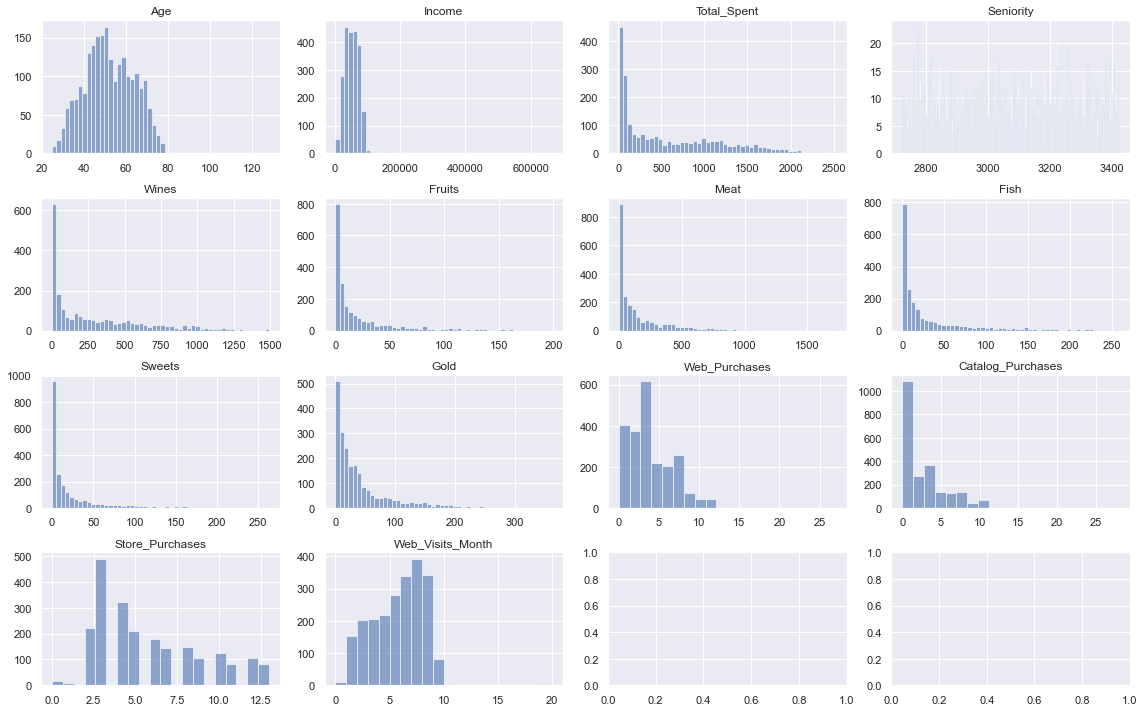

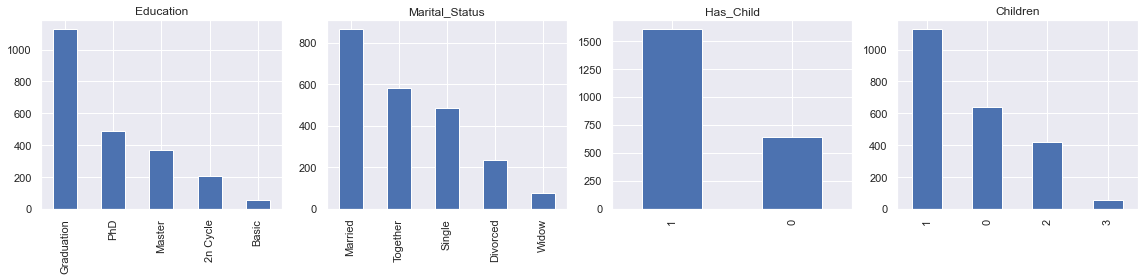

In [8]:
# Plot features after cleaning the data
hist_columns = ['Age', 'Income', 'Total_Spent', 'Seniority', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
bar_columns = ['Education', 'Marital_Status', 'Has_Child', 'Children']

bins = [50, 50, 50, 250, 50, 50, 50, 50, 50, 50, 20, 20, 20, 20]

plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### 1.3 Clean data

In [9]:
# Check amount of initial null values
data_info = pd.DataFrame(columns=['Name of Col', 'Num of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(data.columns)):
    data_info.loc[i] = [data.columns[i],
                        data[data.columns[i]].isnull().sum(),
                        data[data.columns[i]].dtypes,
                        data[data.columns[i]].nunique()] 
    
data_info

,Name of Col,Num of Null,Dtype,N_Unique
0,Age,0,int64,59
1,Education,0,object,5
2,Marital_Status,0,object,5
3,Income,24,float64,1974
4,Total_Spent,0,int64,1054
5,Seniority,0,int16,663
6,Has_Child,0,int32,2
7,Children,0,int64,4
8,Wines,0,int64,776
9,Fruits,0,int64,158


In [10]:
# Fill null values with median income amount according its education level
data['Income'].fillna(data.groupby('Education')['Income'].transform('median'), inplace=True)

In [11]:
# Check the amount of null values after cleaning the data
print(f'Amount of null values after cleaning the data {len(data[data.isna().any(axis=1)])}')

Amount of null values after cleaning the data 0


### 1.4 Remove outliers

In [12]:
def plot_outliers(data, x):
    fig, axes = plt.subplots(2, 1, figsize=(10,6))

    sns.boxplot(data = data, x = x, color = 'red', ax = axes[0])
    sns.histplot(data = data, x = x, kde=True, color='blue', ax = axes[1])
    plt.show()

#### 1.4.1 Income outliers

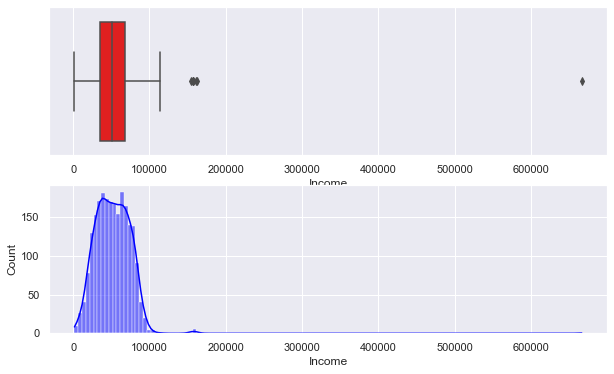

In [13]:
# Plot Income data with outliers
plot_outliers(data, 'Income')

In [14]:
# Define the function for capping the outliers
def cap_outliers(data, x):
    print(f'old shape: {data.shape}')
    q1 = data[x].quantile(0.25)
    q3 = data[x].quantile(0.75)

    iqr = q3 - q1

    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    print(f'upper bound value: {upper_bound}')
    print(f'lower bound value: {lower_bound}')

    data.loc[data[x] > upper_bound, x] = upper_bound
    data.loc[data[x] < lower_bound, x] = lower_bound

    print(f'new shape: {data.shape}, There is no change of the shape.')

In [15]:
# Remove outliers
cap_outliers(data, 'Income')

old shape: (2240, 18)
upper bound value: 117416.25
lower bound value: -13587.75
new shape: (2240, 18), There is no change of the shape.


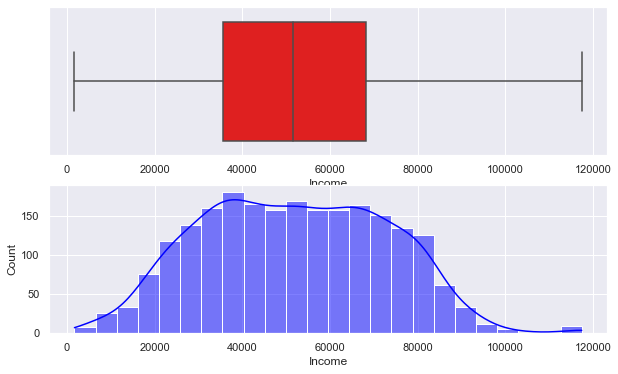

In [16]:
# Plot Income data without outliers
plot_outliers(data, 'Income')

#### 1.4.2 Age outliers

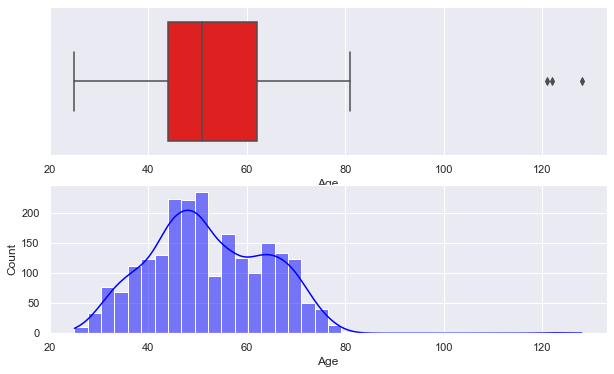

In [17]:
# Plot Age data with outliers
plot_outliers(data, 'Age')

In [18]:
# Capping outliers
cap_outliers(data, 'Age')

old shape: (2240, 18)
upper bound value: 89.0
lower bound value: 17.0
new shape: (2240, 18), There is no change of the shape.


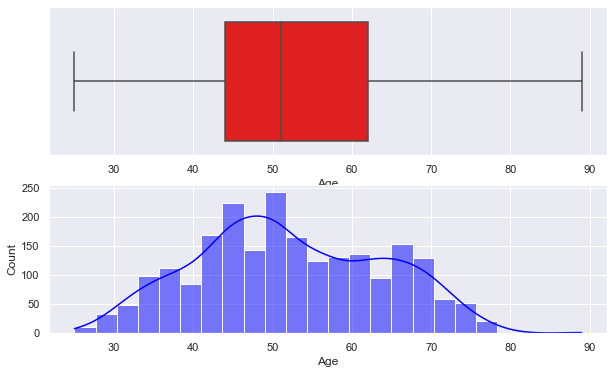

In [19]:
# Plot Age data without outliers
plot_outliers(data, 'Age')

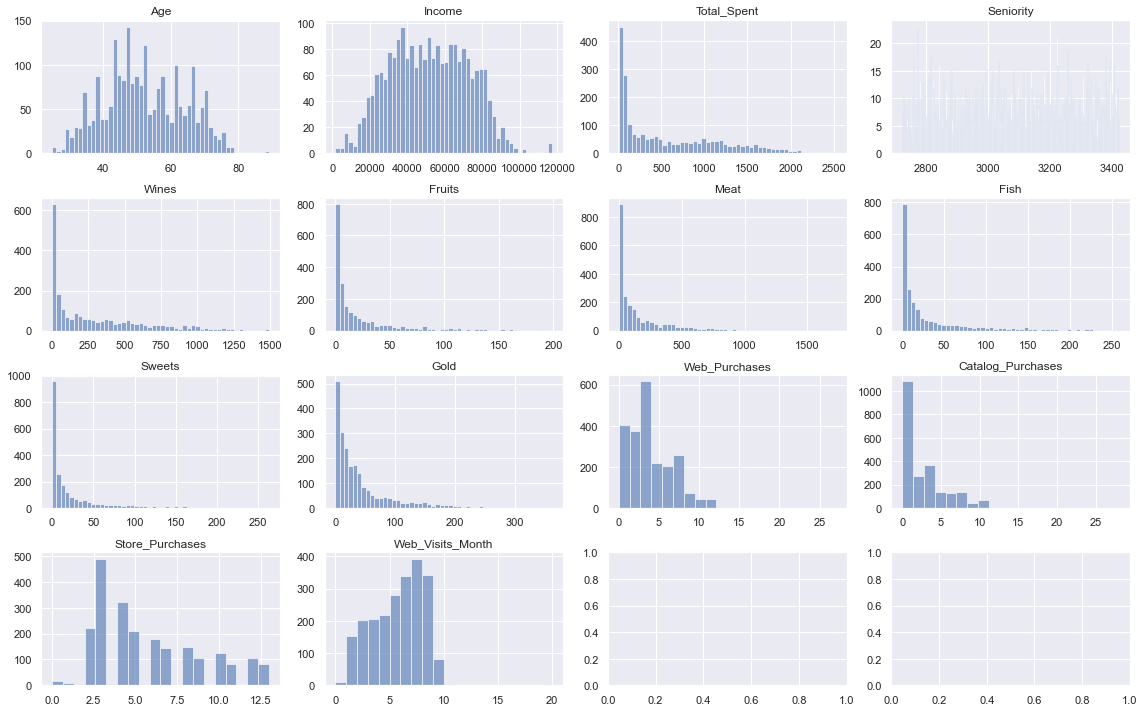

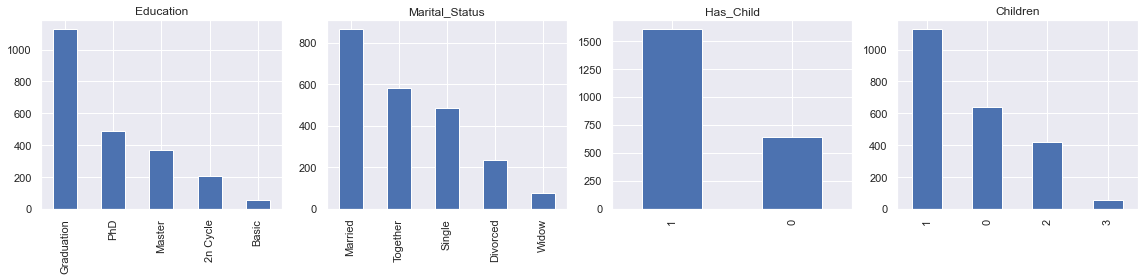

In [20]:
# Plot again after cleaning the data
plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### 1.5 Correlation Analysis

<AxesSubplot:>

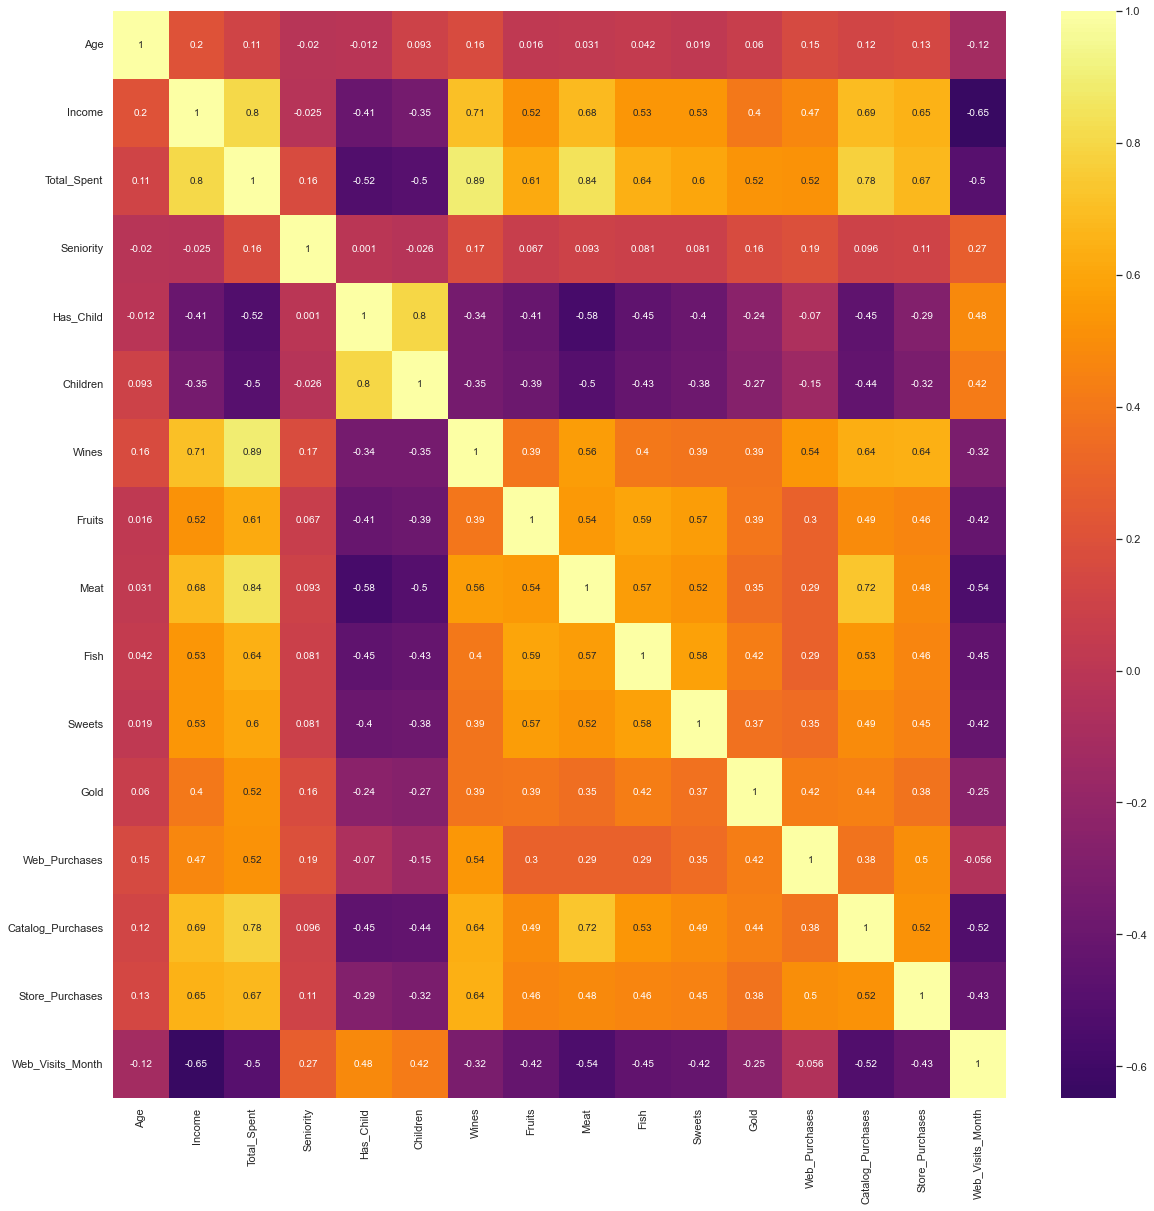

In [21]:
corrmat= data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, cmap='inferno', center=0)

### 1.6 Prepare data

In [22]:
data_to_plot = data
data = pd.get_dummies(data)
data.head()

,Age,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,...,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
ID,,,,,,,,,,,,,,,,,,,,,
5524,64,58138.0,1617,3387,0,0,635,88,546,172,...,0,0,1,0,0,0,0,1,0,0
2174,67,46344.0,27,2837,1,2,11,1,6,2,...,0,0,1,0,0,0,0,1,0,0
4141,56,71613.0,776,3036,0,0,426,49,127,111,...,0,0,1,0,0,0,0,0,1,0
6182,37,26646.0,53,2863,1,1,11,4,20,10,...,0,0,1,0,0,0,0,0,1,0
5324,40,58293.0,422,2885,1,1,173,43,118,46,...,0,0,0,0,1,0,1,0,0,0


In [23]:
# Adding labels to DataFrame
data['Buy_More_Online'] = (data['Web_Purchases'] > data['Store_Purchases'])*1
data['Spent_More_In_Wines_Than_Meat'] = (data['Wines'] > data['Meat'])*1

In [24]:
# Get own labels
y_online = data['Buy_More_Online']
y_spent = data['Spent_More_In_Wines_Than_Meat']

In [25]:
# Drop label columns
data.drop(columns=['Buy_More_Online', 'Spent_More_In_Wines_Than_Meat'], inplace=True)
data.head()

,Age,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,...,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
ID,,,,,,,,,,,,,,,,,,,,,
5524,64,58138.0,1617,3387,0,0,635,88,546,172,...,0,0,1,0,0,0,0,1,0,0
2174,67,46344.0,27,2837,1,2,11,1,6,2,...,0,0,1,0,0,0,0,1,0,0
4141,56,71613.0,776,3036,0,0,426,49,127,111,...,0,0,1,0,0,0,0,0,1,0
6182,37,26646.0,53,2863,1,1,11,4,20,10,...,0,0,1,0,0,0,0,0,1,0
5324,40,58293.0,422,2885,1,1,173,43,118,46,...,0,0,0,0,1,0,1,0,0,0


# 2. Unsupervised Learning

### 2.1 Standarize data

In [26]:
# Standarize data
numeric_columns = ['Age', 'Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Standarized = scaler.fit(data[numeric_columns]).transform(data[numeric_columns])
X_Standarized

array([[ 1.00706384,  0.29941028,  1.53118494, ...,  2.51089024,
        -0.55078479,  0.69390374],
       [ 1.2619687 , -0.26401077, -1.19054458, ..., -0.56871962,
        -1.1661254 , -0.13046347],
       [ 0.32731756,  0.94313578, -0.20577336, ..., -0.22654075,
         1.29523705, -0.54264708],
       ...,
       [-1.032175  ,  0.24413826, -0.98270342, ...,  0.11563813,
         2.21824797,  0.28172013],
       [ 1.09203213,  0.83001207, -0.97775482, ...,  0.79999587,
         1.29523705, -0.95483068],
       [ 1.2619687 ,  0.04770047,  1.32829237, ..., -0.56871962,
        -0.55078479,  0.69390374]])

In [27]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in data.columns if c not in numeric_columns]
X_Standarized = pd.DataFrame(X_Standarized, columns=numeric_columns)
X_complete = pd.concat([X_Standarized, data[cat_cols].reset_index(drop=True)], axis=1)
X_complete

,Age,Income,Seniority,Total_Spent,Wines,Fruits,Meat,Fish,Sweets,Gold,...,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,1.007064,0.299410,1.531185,1.679417,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,...,0,0,1,0,0,0,0,1,0,0
1,1.261969,-0.264011,-1.190545,-0.961275,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,...,0,0,1,0,0,0,0,1,0,0
2,0.327318,0.943136,-0.205773,0.282673,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,...,0,0,1,0,0,0,0,0,1,0
3,-1.287080,-1.205020,-1.061881,-0.918094,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,...,0,0,1,0,0,0,0,0,1,0
4,-1.032175,0.306815,-0.953012,-0.305254,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.157381,0.446786,0.135680,1.221032,1.203678,0.419916,0.066692,0.081926,2.203398,3.891766,...,0,0,1,0,0,0,1,0,0,0
2236,1.941715,0.580118,-1.655713,-0.268717,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,-0.690659,...,0,0,0,0,1,0,0,0,1,0
2237,-1.032175,0.244138,-0.982703,1.054951,1.795020,0.545656,0.221789,-0.101168,-0.364974,-0.383886,...,0,0,1,0,0,1,0,0,0,0
2238,1.092032,0.830012,-0.977755,0.393948,0.368666,0.092992,0.208495,0.777683,0.071165,0.325527,...,0,0,0,1,0,0,0,0,1,0


#### Define Methods to get best k value

In [28]:
# Quick examination of elbow method to find numbers of clusters to make.
def get_best_k_elbow(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=0).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    plt.title("Elbow Method")

### 2.2 Fit_predict without PCA

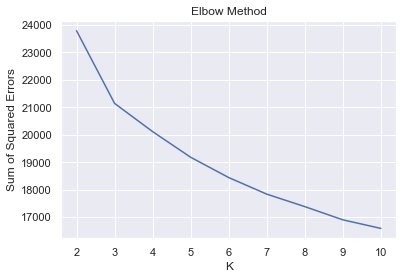

In [29]:
# Elbow method
get_best_k_elbow(X_complete)

In [30]:
# Get KMeans labels
best_k = 3
labels = KMeans(n_clusters=best_k, random_state=0).fit_predict(X_complete)

In [31]:
data_to_plot['Cluster'] = labels
data_to_plot

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month,Cluster
ID,,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7,2
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5,1
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4,0
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6,1
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,54,Graduation,Married,61223.0,1341,3105,1,1,709,43,182,42,118,247,9,3,4,5,0
4001,75,PhD,Together,64014.0,444,2743,1,3,406,0,30,0,0,8,8,2,5,7,0
7270,40,Graduation,Divorced,56981.0,1241,2879,0,0,908,48,217,32,12,24,2,3,13,6,0


### 2.3 Fit_predict with PCA

In [32]:
#Initiating PCA to reduce dimentions aka features to 3
X_PCA = PCA(.95, random_state=0).fit(X_complete).transform(X_complete)
PCA_ds = pd.DataFrame(X_PCA)
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
0,2240.0,4.739265e-16,2.639371,-4.975359,-2.437414,-0.754089,2.283768,7.338563
1,2240.0,4.430979e-17,1.218650,-3.889342,-0.887197,-0.093779,0.826338,3.980641
2,2240.0,-8.624054e-18,1.106005,-3.253053,-0.791777,-0.019328,0.773435,3.962016
3,2240.0,1.633118e-17,0.923827,-4.932541,-0.483608,0.014871,0.455546,5.411807
4,2240.0,-1.051738e-16,0.885644,-4.417893,-0.570266,0.034547,0.580412,5.462043
5,2240.0,8.227546e-18,0.799574,-3.454978,-0.329687,-0.051387,0.255723,4.015224
6,2240.0,-1.987497e-17,0.703884,-2.394894,-0.419676,-0.012630,0.410877,4.195301
7,2240.0,8.029292e-18,0.669704,-3.340257,-0.270344,0.000206,0.276051,5.801558
8,2240.0,2.309660e-17,0.656908,-3.377069,-0.338904,-0.024079,0.440431,3.464284
9,2240.0,2.065560e-17,0.629094,-2.676599,-0.208818,0.005609,0.183923,3.702814


#### 2.3.1 Elbow Method

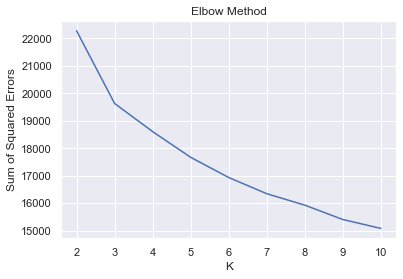

In [33]:
get_best_k_elbow(PCA_ds)

#### 2.3.3 Clustering

In [34]:
# Get KMeans labels
best_k_PCA = 3
labels_PCA = KMeans(n_clusters=best_k_PCA, random_state=0).fit_predict(PCA_ds)

In [35]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds[0]
y =PCA_ds[1]
z =PCA_ds[2]
PCA_ds['Clusters_PCA'] = labels_PCA
data_to_plot['Clusters_PCA'] = labels_PCA

In [36]:
data_to_plot.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month,Cluster,Clusters_PCA
ID,,,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7,2,0
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5,1,1
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4,0,2
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6,1,1
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5,0,2


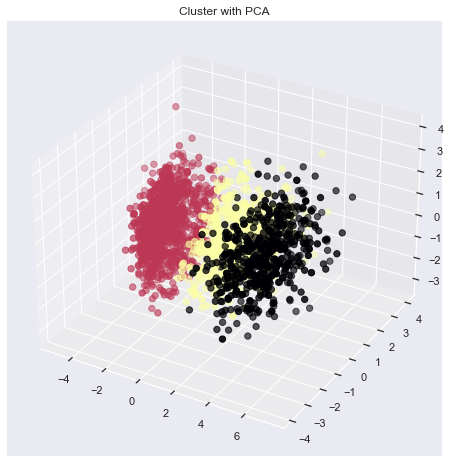

In [37]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds['Clusters_PCA'], marker='o', cmap='inferno')
ax.set_title("Cluster with PCA")
plt.show()

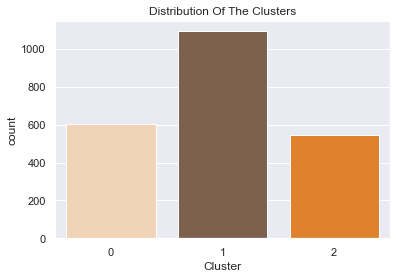

In [38]:
#Plotting countplot of clusters
pal = ['#FAD3AE', '#855E46', '#FE800F']
pl = sns.countplot(x=data_to_plot['Cluster'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

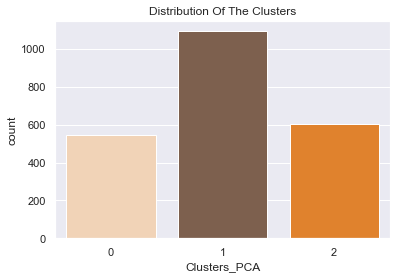

In [72]:
pal = ['#FAD3AE', '#855E46', '#FE800F']
pl = sns.countplot(x=data_to_plot['Clusters_PCA'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

#### 2.3.1 Customers Profiling

* Purchasing behavior by clusters: 
'Spent_All', 'PurDeal_PurAll_ratio', 'NumWebVisitsMonth', 'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases', 'NumWebPurchases'
* Personal information by clusters
'Income', 'Age', 'Education', 'Is_Parent', Family_Size', 'Kidhome', 'Teenhome'

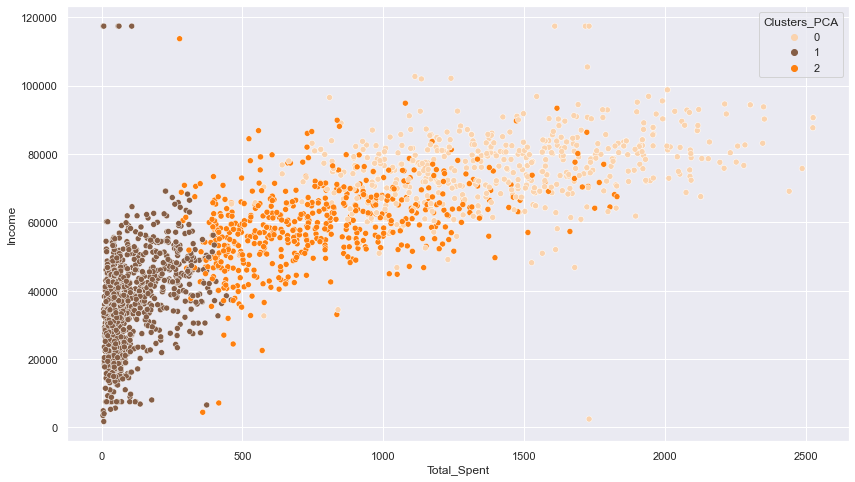

In [73]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=data_to_plot["Total_Spent"], y=data_to_plot["Income"], hue=data_to_plot["Clusters_PCA"], palette=pal);

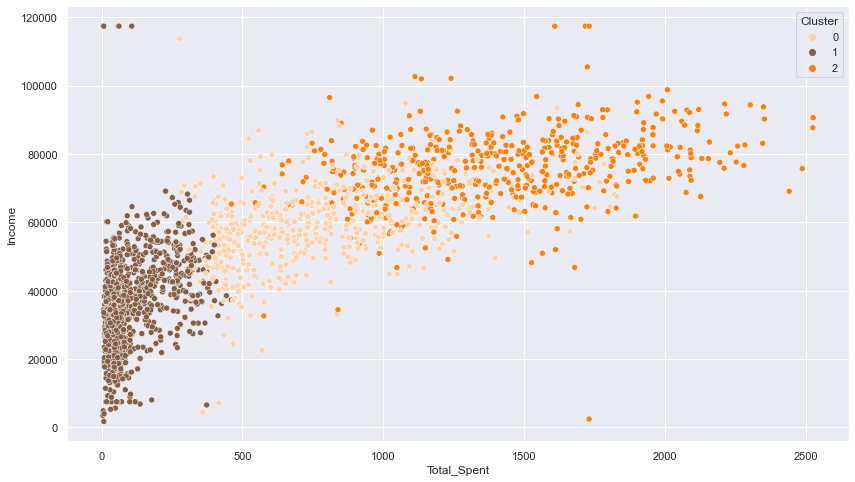

In [ ]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=data_to_plot["Total_Spent"], y=data_to_plot["Income"], hue=data_to_plot["Cluster"], palette=pal);

* Group 0: low spend - low income
* Group 1: high spend - average income
* Group 2: high spend - high income
* Group 3: low spend - average income

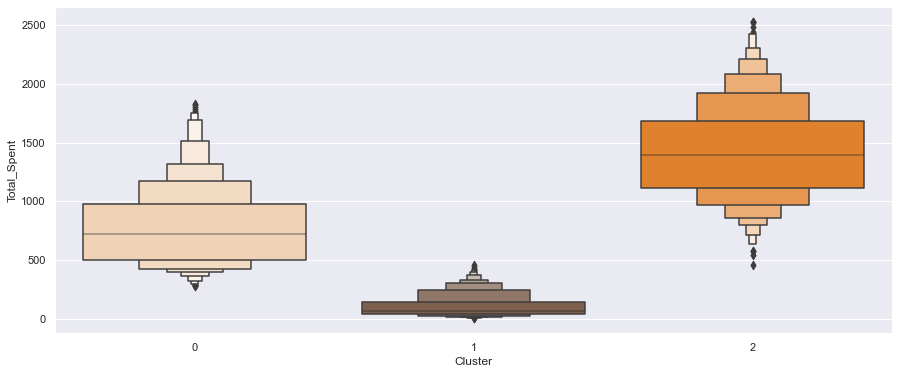

In [40]:
plt.figure(figsize=(15,6))
pl=sns.boxenplot(x=data_to_plot["Cluster"], y=data_to_plot["Total_Spent"], palette=pal)
plt.show()


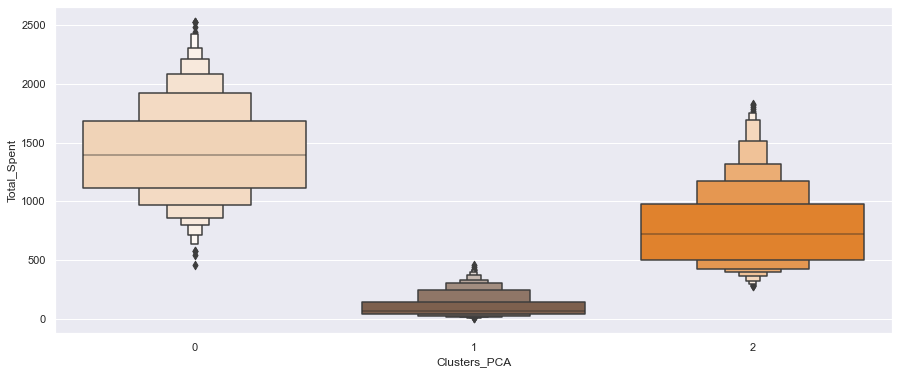

In [74]:
plt.figure(figsize=(15,6))
pl=sns.boxenplot(x=data_to_plot["Clusters_PCA"], y=data_to_plot["Total_Spent"], palette=pal)
plt.show()

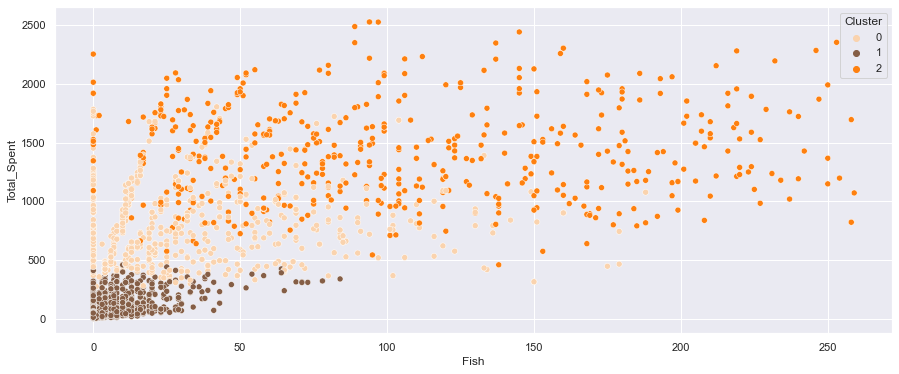

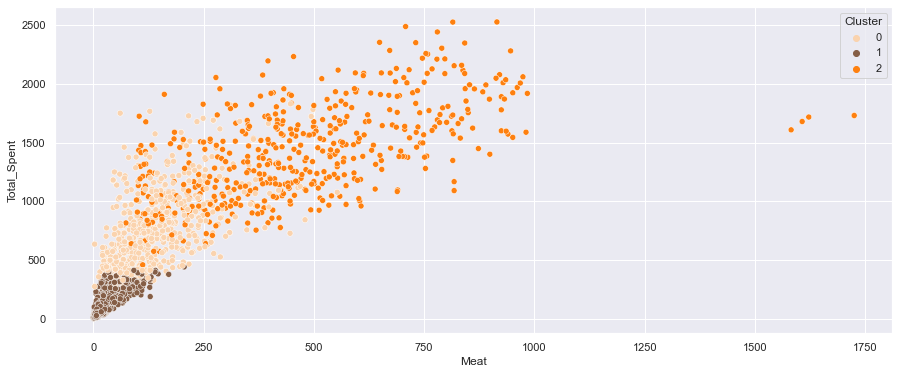

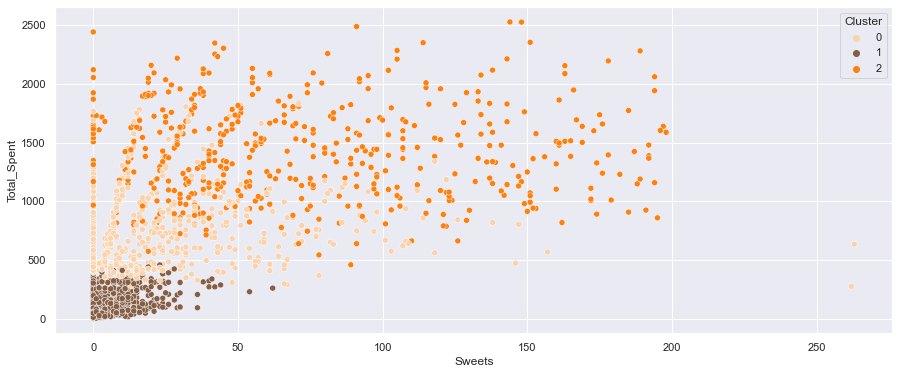

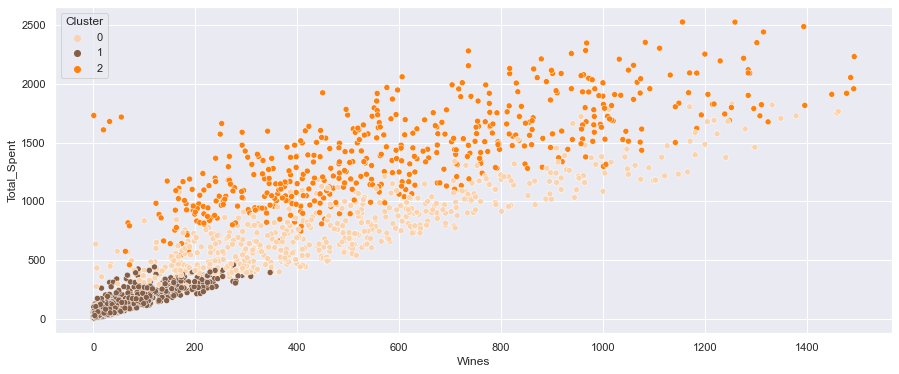

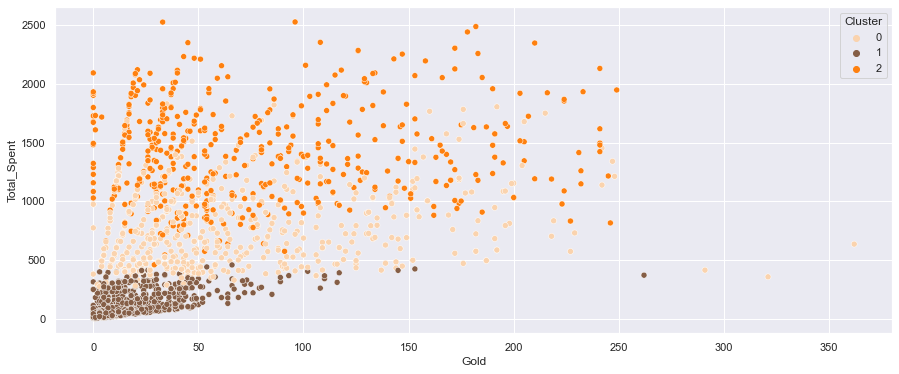

In [41]:
prod = ['Fish', 'Meat', 'Sweets', 'Wines', 'Gold']
for i in prod:
    plt.figure(figsize=(15,6))
    sns.scatterplot(x=i, y="Total_Spent", palette=pal ,data=data_to_plot, hue=data_to_plot["Cluster"]);

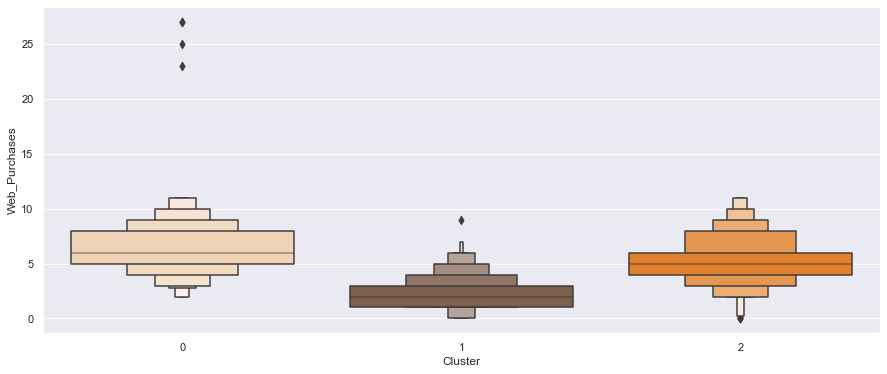

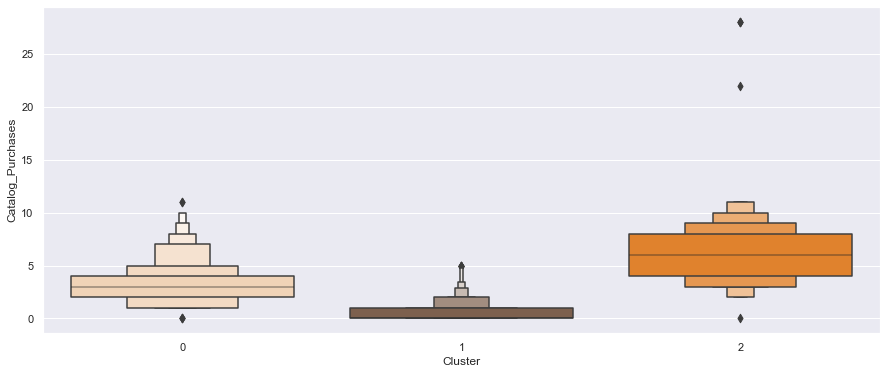

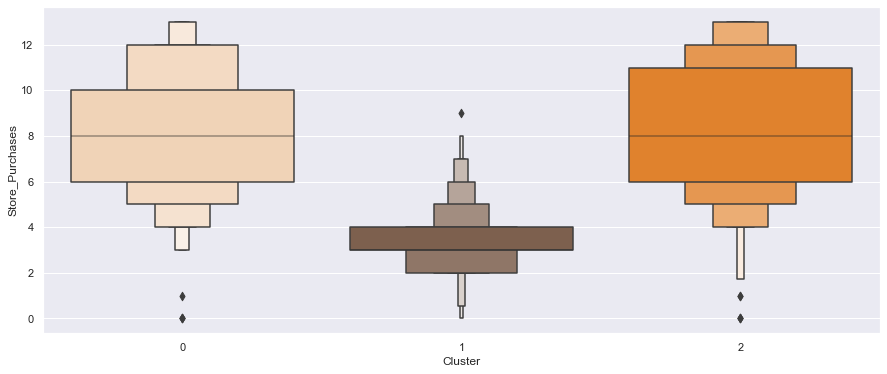

In [42]:
place = ["Web_Purchases", "Catalog_Purchases", "Store_Purchases"]
for i in place:
    plt.figure(figsize=(15,6))
    sns.boxenplot(x="Cluster", y=i, palette=pal ,data=data_to_plot);
    plt.show()

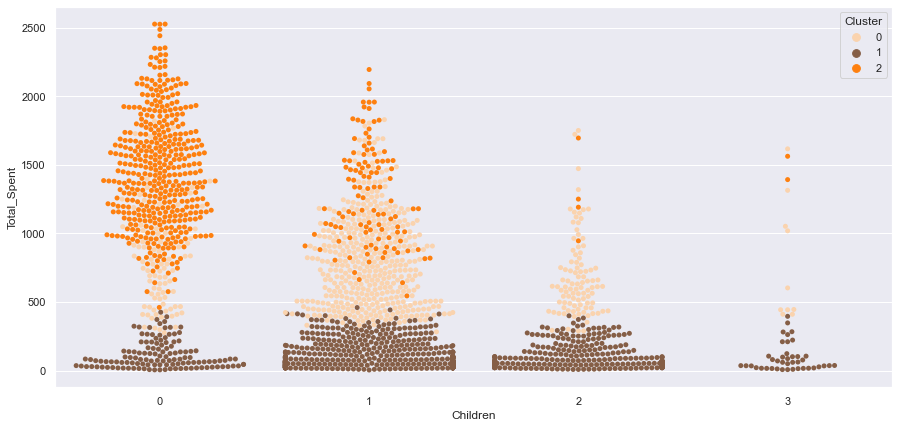

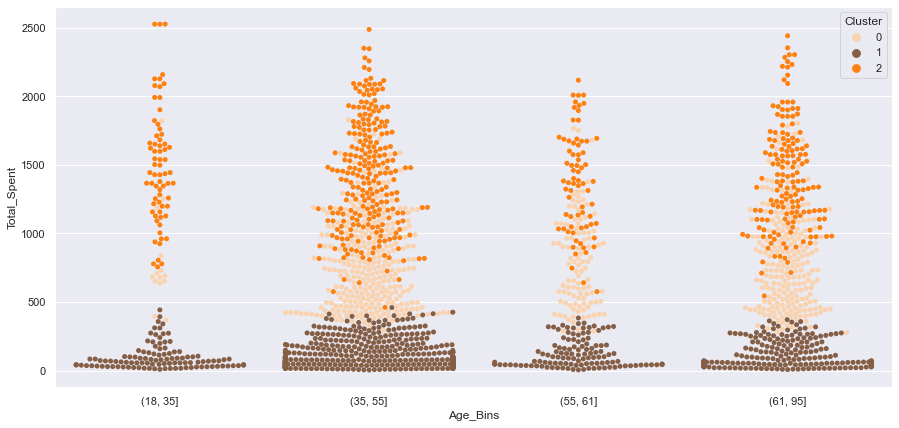

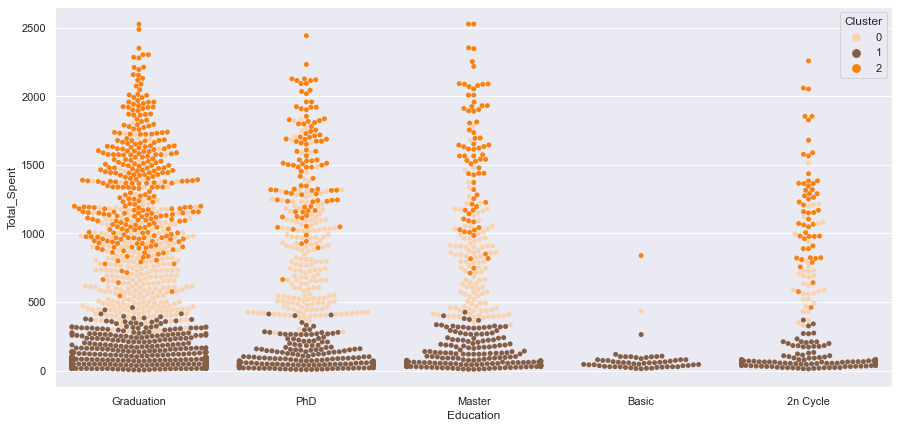

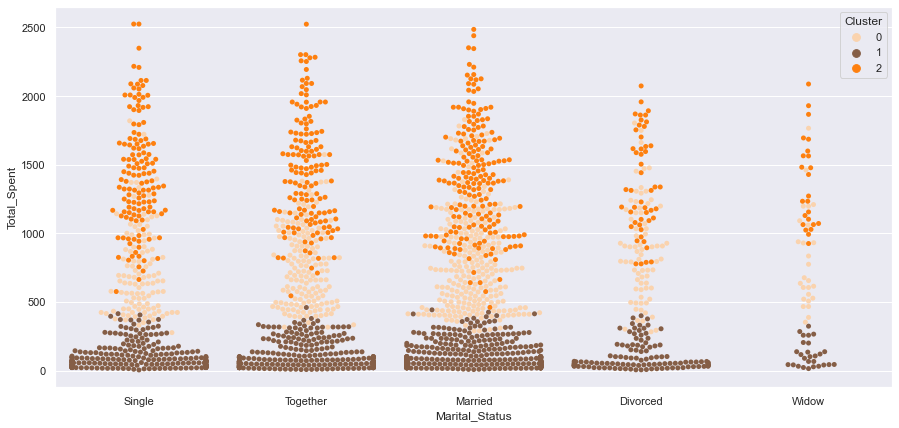

In [43]:
data_to_plot["Age_Bins"] = pd.cut(x=data["Age"], bins=[18,35,55,61,95])
prf = ["Children", "Age_Bins", "Education", "Marital_Status"]
for i in prf:
    plt.figure(figsize=(15,7))
    sns.swarmplot(x=i, y="Total_Spent", hue="Cluster", palette=pal ,data=data_to_plot)
    plt.show()

# 3. Supervised Learning

### 3.1 First Model: (Online purchases vs storage purchases)

In [44]:
# Split data in training and testing sets (80% train - 20% test)
x_train, x_test, y_train, y_test = train_test_split(data, y_online, test_size = 0.20)

#### 3.1.1 Standarization

In [45]:
# Standarize data
numeric_columns = ['Age', 'Income', 'Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold','Catalog_Purchases', 'Web_Visits_Month']
excluded_columns = [ 'Web_Purchases', 'Store_Purchases']
scaler = StandardScaler()

X_Train_Standarized = scaler.fit(x_train[numeric_columns]).transform(x_train[numeric_columns])
X_Test_Standarized = scaler.transform(x_test[numeric_columns])
X_Train_Standarized

array([[-0.85632646, -1.2929956 ,  1.5381572 , ...,  1.39027608,
        -0.55744382,  1.07895641],
       [ 1.69287951, -0.18817498,  0.19985806, ..., -0.23884666,
        -0.22121382,  0.67327242],
       [-0.60140586, -0.25798625, -1.51375744, ..., -0.56855007,
        -0.55744382,  0.26758844],
       ...,
       [ 1.09806478,  0.63616073,  1.12333385, ..., -0.00611484,
         0.78747617, -0.54377954],
       [ 1.86282657,  1.43331582, -1.44955859, ..., -0.84007052,
         0.78747617, -1.76083151],
       [-0.51643233,  1.0325686 , -1.61252491, ..., -0.21945234,
         0.45124617, -1.35514752]])

In [46]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in x_train.columns if c not in numeric_columns and c not in excluded_columns]
X_Train_Standarized = pd.DataFrame(X_Train_Standarized, columns=numeric_columns)
X_Train_complete = pd.concat([X_Train_Standarized, x_train[cat_cols].reset_index(drop=True)], axis=1)

X_Test_Standarized = pd.DataFrame(X_Test_Standarized, columns=numeric_columns)
X_Test_complete = pd.concat([X_Test_Standarized, x_test[cat_cols].reset_index(drop=True)], axis=1)

#### * Define functions

In [47]:
import time
precision_list = []
recall_list = []
f1score_list = []
exec_list = []

In [48]:
def calculate_metrics(adopt_predict_probabilities):
    precision = precision_score(y_test, adopt_predict_probabilities, zero_division=1, average="binary")
    precision_list.append(precision)

    recall = recall_score(y_test, adopt_predict_probabilities, average="binary")
    recall_list.append(recall)

    f1score = f1_score(y_test, adopt_predict_probabilities, average="binary")
    f1score_list.append(f1score)

#### 3.1.2 Train-Predict Model with multiple Classifiers

In [49]:
# Support Vector Machines
svm = svm.SVC(C=0.1, max_iter=100, random_state=0)

init_time = time.time()
svm.fit(X_Train_complete, y_train)
predict_svm = svm.predict(X_Test_complete)
final_time = time.time()

exec_list.append(final_time-init_time)

In [50]:
# Stochastic Gradient Descent
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=200, alpha=1e-5, random_state=0)
init_time = time.time()
sgd.fit(X_Train_complete, y_train)
predict_sgd = sgd.predict(X_Test_complete)
final_time = time.time()

exec_list.append(final_time-init_time)

In [51]:
# Nearest Neighbors
neigh_15 = KNeighborsClassifier(n_neighbors=15)

init_time = time.time()
neigh_15.fit(X_Train_complete, y_train)
predict_neigh_15 = neigh_15.predict(X_Test_complete)
final_time = time.time()

exec_list.append(final_time-init_time)

In [52]:
# Naive Bayes
gnb = GaussianNB()

init_time = time.time()
gnb.fit(X_Train_complete, y_train)
predict_gnb = gnb.predict(X_Test_complete)
final_time = time.time()

exec_list.append(final_time-init_time)

In [53]:
# GradientBoostingClassifier(Ensemble methods)
est = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

init_time = time.time()
est.fit(X_Train_complete, y_train)
predict_est = est.predict(X_Test_complete)
final_time = time.time()

exec_list.append(final_time-init_time)

In [54]:
# MLP Classifier
mlp = MLPClassifier(alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=0)

init_time = time.time()
mlp.fit(X_Train_complete, y_train)
predict_mlp = mlp.predict(X_Test_complete)
final_time = time.time()

exec_list.append(final_time-init_time)

#### 3.1.3 Calculate classifier's metrics

In [55]:
# Calculate metrics
calculate_metrics(predict_svm)
calculate_metrics(predict_sgd)
calculate_metrics(predict_neigh_15)
calculate_metrics(predict_gnb)
calculate_metrics(predict_est)
calculate_metrics(predict_mlp)

In [56]:
# Create a DataFrame of metrics
classifiers = ['Support Vector Machines', 'Stochastic Gradient Descent', 'Nearest Neighbors K=15', 'Naive Bayes', 'Ensemble', 'MLP']
metrics = {'Precision': precision_list,'Recall': recall_list, 'F1-Score':f1score_list, 'Execution-Time': exec_list}

metrics_classifiers_df = pd.DataFrame(metrics, index=classifiers)
metrics_classifiers_df

,Precision,Recall,F1-Score,Execution-Time
Support Vector Machines,0.283237,0.628205,0.390438,0.037999
Stochastic Gradient Descent,0.492308,0.410256,0.447552,0.025014
Nearest Neighbors K=15,0.600000,0.115385,0.193548,0.054002
Naive Bayes,0.349057,0.474359,0.402174,0.006999
Ensemble,0.548387,0.435897,0.485714,0.257654
MLP,0.529412,0.230769,0.321429,1.048992


#### Plot metrics

Text(0.5, 1.0, 'Execution Time')

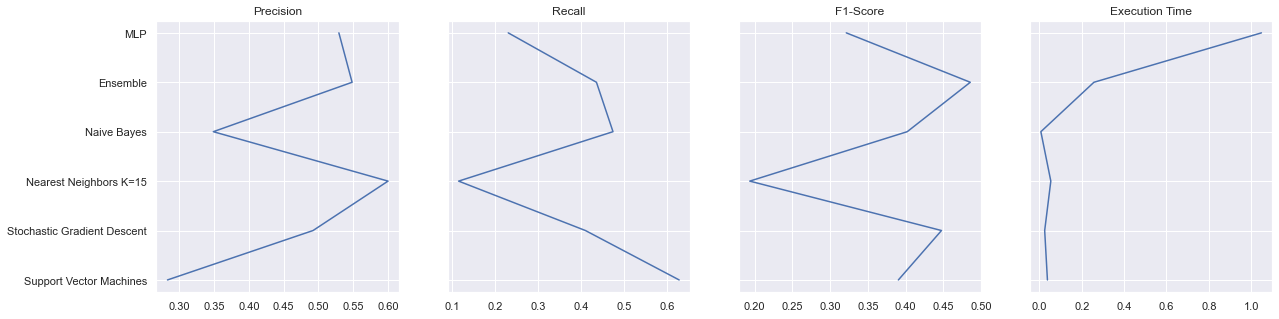

In [57]:
fig, axs = plt.subplots(1, 4, figsize=(20,5), sharey=True)

# Plot metrics
plt.sca(axs[0])
plt.plot(metrics_classifiers_df.Precision, classifiers)
plt.title("Precision")

plt.sca(axs[1])
plt.plot(metrics_classifiers_df.Recall, classifiers)
plt.title("Recall")

plt.sca(axs[2])
plt.plot(metrics_classifiers_df['F1-Score'], classifiers)
plt.title("F1-Score")

plt.sca(axs[3])
plt.plot(metrics_classifiers_df['Execution-Time'], classifiers)
plt.title("Execution Time")

#### 3.1.4 Plot Confusion Matrix

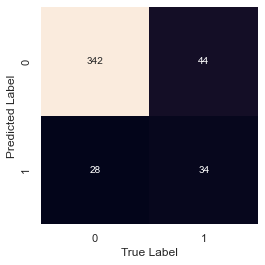

In [58]:
matrix = confusion_matrix(y_test, predict_est)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.show()

In [59]:
precision_list = []
recall_list = []
f1score_list = []

In [60]:
calculate_metrics(predict_est)

In [61]:
print(f'Precision: {precision_list}')
print(f'Recall: {recall_list}')
print(f'F1-Score: {f1score_list}')

Precision: [0.5483870967741935]
Recall: [0.4358974358974359]
F1-Score: [0.4857142857142857]


#### 3.1.5 Predict with own data

In [62]:
woman = pd.DataFrame([[30, 45000, 1341, 1617, 550, 202, 160, 89, 130, 200, 3, 5, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]])
woman_predict = est.predict_proba(woman)[:1]
print(woman_predict)

[[0. 1.]]


### 3.2 Second Model: (Spent more in Wine than Meat)

#### 3.2.1 Standarization

In [63]:
# Split data in training and testing sets (80% train - 20% test)
x_train, x_test, y_train, y_test = train_test_split(data, y_spent, test_size = 0.20)

In [64]:
# Standarize data
numeric_columns = ['Age', 'Income', 'Seniority','Total_Spent', 'Fruits', 'Fish', 'Sweets', 'Gold', 'Web_Purchases','Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
excluded_columns = ['Wines', 'Meat']
scaler = StandardScaler()

X_Train_Standarized = scaler.fit(x_train[numeric_columns]).transform(x_train[numeric_columns])
X_Test_Standarized = scaler.transform(x_test[numeric_columns])

In [65]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in x_train.columns if c not in numeric_columns and c not in excluded_columns]
X_Train_Standarized = pd.DataFrame(X_Train_Standarized, columns=numeric_columns)
X_Train_complete = pd.concat([X_Train_Standarized, x_train[cat_cols].reset_index(drop=True)], axis=1)

X_Test_Standarized = pd.DataFrame(X_Test_Standarized, columns=numeric_columns)
X_Test_complete = pd.concat([X_Test_Standarized, x_test[cat_cols].reset_index(drop=True)], axis=1)

#### 3.2.2 Train Model (GradientBoostingClassifier)

In [66]:
# GradientBoostingClassifier(Ensemble methods)
est = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

est.fit(X_Train_complete, y_train)
predict_est = est.predict(X_Test_complete)

#### 3.2.3 Plot Confusion Matrix

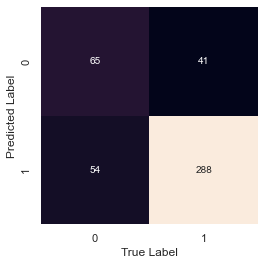

In [67]:
matrix = confusion_matrix(y_test, predict_est)
sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0,1],
            yticklabels=[0,1])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');
plt.show()

#### 3.2.4 Calculate classifier's metrics

In [68]:
precision_list = []
recall_list = []
f1score_list = []

In [69]:
calculate_metrics(predict_est)

In [70]:
print(f'Precision: {precision_list}')
print(f'Recall: {recall_list}')
print(f'F1-Score: {f1score_list}')

Precision: [0.8421052631578947]
Recall: [0.8753799392097265]
F1-Score: [0.8584202682563338]


#### 3.2.5 Predict with own data

In [71]:
man = pd.DataFrame([[50, 30000, 2880, 503, 49, 59, 11, 22, 8, 2, 10, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]])
man_predict = est.predict_proba(man)[:1]
print(man_predict)

[[0.00270666 0.99729334]]
